current samples: ['0.8489', '0.2591']


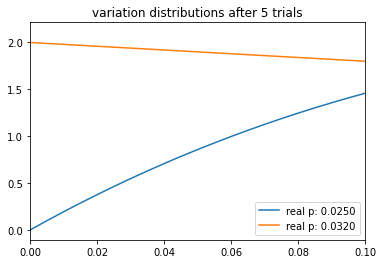

current samples: ['0.1172', '0.2570']


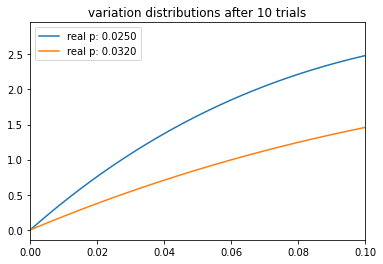

current samples: ['0.3008', '0.2261']


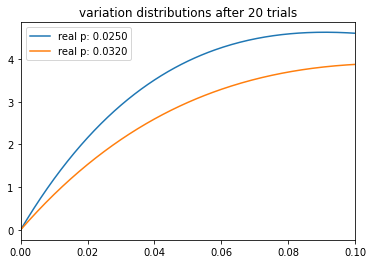

current samples: ['0.1078', '0.0516']


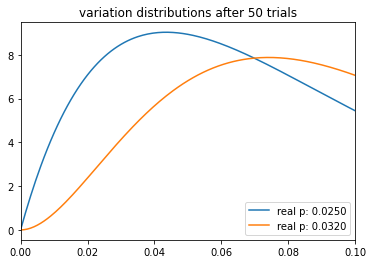

current samples: ['0.1179', '0.0827']


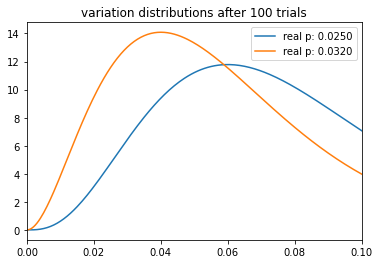

current samples: ['0.0198', '0.0331']


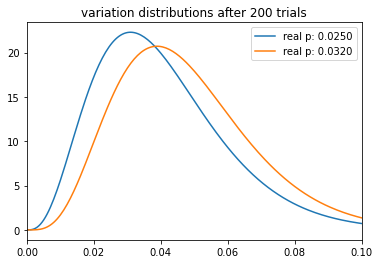

current samples: ['0.0114', '0.0423']


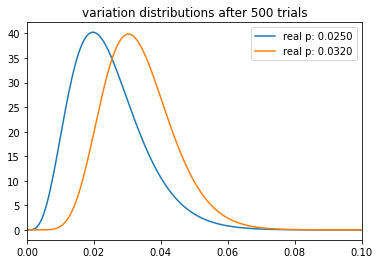

current samples: ['0.0218', '0.0336']


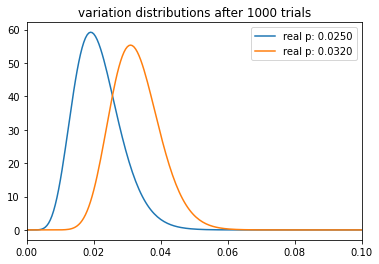

current samples: ['0.0240', '0.0391']


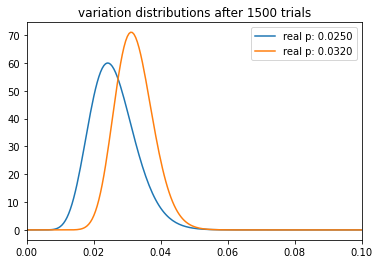

current samples: ['0.0311', '0.0340']


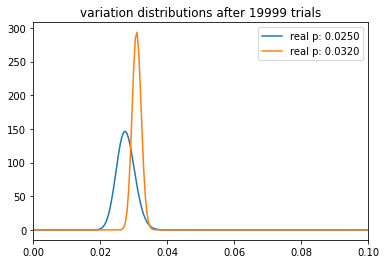

After running 20000 trials and 100000 Monte Carlo simulations:
Wins for 0.025 variation: 0.142
[0.02237502 0.03307841]
Wins for 0.032 variation: 0.858
[0.02831221 0.03361324]


In [64]:
# https://www.dynamicyield.com/lesson/bayesian-approach-to-ab-testing/
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta
import arviz as az

NUM_SIMULATIONS = 100000
NUM_TRIALS = 20000
CLICK_PROBABILITIES = [0.025,0.032]

class Variation(object):
  def __init__(self, p):
    self.p = p
    self.a = 1
    self.b = 1
    self.simulationWins = 0

  def showVariation(self):
    return np.random.random() < self.p

  def sampleVariation(self):
    return np.random.beta(self.a, self.b)

  def multiSample(self):
    return beta.rvs(self.a, self.b, size=NUM_SIMULATIONS)

  def simulationWin(self):
    self.simulationWins += 1
  
  def winPercentage(self, total):
    return self.simulationWins / total
    
  def updateVariation(self, x):
    self.a += x
    self.b += 1 - x

    
def plot(variations, trial):
  x = np.linspace(0, 1, 2000)
  for b in variations:
    y = beta.pdf(x, b.a, b.b)
    plt.plot(x, y, label="real p: %.4f" % b.p)
  plt.title("variation distributions after %s trials" % trial)
  plt.legend()
  axes = plt.gca()
  axes.set_xlim([0,.10])
  plt.show()

def runTrial( variations ):
  # take a sample from each variation
  bestVariation = None
  maxsample = -1
  allsamples = []

  for v in variations:
    sample = v.sampleVariation()
    allsamples.append("%.4f" % sample)
    if sample > maxsample:
      maxsample = sample
      bestVariation = v
  
  return bestVariation, allsamples

def experiment():
  variations = [Variation(p) for p in CLICK_PROBABILITIES]
  sample_points = [5,10,20,50,100,200,500,1000,1500, (NUM_TRIALS - 1) ]

  for i in range(NUM_TRIALS):

    bestVariation, allsamples = runTrial( variations )
        
    if i in sample_points:
      print("current samples: %s" % allsamples)
      plot(variations, i)
    
    # show the variation with the largest sample
    x = bestVariation.showVariation()
    
    # update the distribution for the variation which was just sampled
    bestVariation.updateVariation(x)

  # Monte Carlo Simulation
  for s in range(NUM_SIMULATIONS):
    bestVariation, allsamples = runTrial( variations )
    bestVariation.simulationWin()

  print( "After running %d trials and %d Monte Carlo simulations:" % ( NUM_TRIALS, NUM_SIMULATIONS ) )
  for v in variations:
    print("Wins for %s variation: %.3f" % ( v.p, v.winPercentage(NUM_SIMULATIONS) ) )
    simData = v.multiSample()
    print( az.hdi(simData, hdi_prob=.95) )


experiment()
